<h1>EDA for Weather and Air Quality Dataset</h1>

Name: Abdul Qaiyum Lee Bin Abdul Aziz<br/>
Email: abdulqaiyumlee@gmail.com

<h2>Overview</h2>

1. [Importing the Datasets](#importing-the-datasets)
2. [Weather data preliminary investigation](#weather-data-preliminary-investigation)
3. [Weather data cleaning](#weather-data-cleaning)
4. [Air Quality data preliminary investigation](#air-quality-data-preliminary-investigation)
5. [Air Quality data cleaning](#air-quality-data-cleaning)
6. [Feature Engineering](#feature-engineering)
7. [Data Exploration](#data-exploration)
   - [Numerical Variables](#numerical-variables)
   - [Categorical Variables](#categorical-variables)
8. [Summary](#summary)

## Importing the Datasets

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Paths to the database files
weather_dir = 'src/data/weather.db'
air_quality_dir = 'src/data/air_quality.db'

# Create engine instances for the databases
weather_engine = create_engine('sqlite:///' + weather_dir)
air_quality_engine = create_engine('sqlite:///' + air_quality_dir)

# Create inspector instances and query the tables
inspector_weather = inspect(weather_engine)
weather_table = inspector_weather.get_table_names()

inspector_air_quality = inspect(air_quality_engine)
air_quality_table = inspector_air_quality.get_table_names()

print(weather_table)
print(air_quality_table)

['weather']
['air_quality']


Let us first perform preliminary investigations on both tables individually

In [3]:
query1 = 'SELECT * FROM weather'
query2 = 'SELECT * FROM air_quality'
# Read the query into a DataFrames
weather_raw = pd.read_sql_query(query1, weather_engine)
air_quality_raw = pd.read_sql_query(query2, air_quality_engine)

# Close the connections
weather_engine.dispose()
air_quality_engine.dispose()

## Weather data preliminary investigation


In [4]:
print(weather_raw.shape)
weather_raw.head()

(3517, 18)


,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low


In [5]:
weather_raw.dtypes

data_ref                          object
date                              object
Daily Rainfall Total (mm)         object
Highest 30 Min Rainfall (mm)      object
Highest 60 Min Rainfall (mm)      object
Highest 120 Min Rainfall (mm)     object
Min Temperature (deg C)           object
Maximum Temperature (deg C)       object
Min Wind Speed (km/h)             object
Max Wind Speed (km/h)             object
Sunshine Duration (hrs)          float64
Cloud Cover (%)                  float64
Wet Bulb Temperature (deg F)     float64
Relative Humidity (%)            float64
Air Pressure (hPa)                 int64
Dew Point Category                object
Wind Direction                    object
Daily Solar Panel Efficiency      object
dtype: object

- Many of the columns are not in the correct data type. One observation from printing the first few rows of the dataset was that some of the supposed numerical columns such as `Daily Rainfall Total` and `Maximum Temperature` contain values such as '--' or '-' to represent Null values.

- We want to convert the columns from object to numeric so that we can have a more insightful analysis

In [6]:
# List of columns to convert to numeric
columns_to_convert = ['Daily Rainfall Total (mm)', 'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)' ]

# Convert each specified column to float
for column in columns_to_convert:
    weather_raw[column] = pd.to_numeric(weather_raw[column], errors='coerce')

In [7]:
weather_raw.head(6)

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,NaN,2.0,2.0,2.0,28.4,32.4,7.5,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0.0,0.0,0.0,NaN,28.8,32.6,NaN,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0.0,0.0,0.0,0.0,29.3,NaN,NaN,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0.0,0.0,0.0,0.0,28.6,32.4,7.4,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28.0,5.4,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low
5,01301ca7-b470-4e55-aa94-d11fd84cb014,06/04/2014,0.2,0.2,0.2,0.2,28.0,32.5,10.4,34.6,7.39,13.0,59.1,81.7,1009,High,NORTHEAST,Low


In [8]:
weather_raw.describe()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3176.000000,3156.000000,3155.000000,3167.000000,3179.000000,3171.000000,3170.000000,3147.000000,3501.000000,3501.000000,3517.000000,3517.000000,3517.000000
mean,5.249780,3.147719,3.757274,4.339754,28.070840,31.730842,8.785079,29.789323,7.018320,28.682376,52.946062,97.366761,1008.668467
std,12.523275,6.660892,8.269569,9.546255,1.092339,1.480824,3.018955,14.943342,1.389904,20.788299,25.842174,5.043705,3.513724
min,0.000000,0.000000,0.000000,0.000000,23.000000,23.700000,0.400000,-59.800000,0.000000,2.000000,-60.700000,68.600000,998.000000
25%,0.000000,0.000000,0.000000,0.000000,27.400000,31.000000,6.500000,27.800000,6.710000,17.000000,58.400000,96.700000,1006.000000
50%,0.000000,0.000000,0.000000,0.000000,28.200000,32.000000,8.000000,31.500000,7.400000,22.000000,58.900000,100.000000,1009.000000
75%,4.000000,2.600000,3.000000,3.600000,28.900000,32.700000,10.800000,36.000000,7.840000,30.000000,59.400000,100.000000,1011.000000
max,210.600000,53.400000,73.800000,85.600000,30.700000,35.400000,21.400000,70.600000,9.150000,100.000000,61.800000,100.000000,1020.000000


<h3>At first glance</h3>

- The max values for the rainfall columns are significantly higher than the 75th percentile values. We will look into this during the data exploration.

- `Min Wind Speed`: The lowest value is -59.8, which is definitely an error. This will be handled during data cleaning.

- `Wet Bulb Temperature`: The lowest temperature is -60.7, which means there is an error in the dataset. This will also be handled during data cleaning.

- Another observation is that `Wet Bulb Temperature` is in degrees Farenheit while `Min Temperature` and `Maximum Temperature` are in degrees Celcius. It is important to standardise the unit of measurement to ensure a more accurate machine learning prediction.


In [9]:
weather_raw.describe(include='object')

,data_ref,date,Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
count,3517,3517,3517,3517,3517
unique,3197,3197,25,32,3
top,43b44edb-37bf-4209-8df5-cd202145c6cf,19/02/2016,High,SW,Medium
freq,3,3,1332,406,1932



- Since the unique values for `data_ref` and `date` are the same, it can be assumed that there is one data entry for each date. Furthermore, there are 3517 entries in total but only 3197 unique `data_ref`/`date` values, we assumed that there are 3517 - 3197 = 320 duplicate rows. These rows will be removed during data cleaning

- `Dew Point Category`: Has 25 unique values which is strange. This is due to spelling differences for the same category. For example "VH" and "Very High" both represent the same thing.

- `Wind Direction`: Has 32 unique values which is also strange. Same rationale as `Dew Point Category`.

## Weather data cleaning


Based on the preliminary analysis, here is a checklist of what we need to clean:

1. Remove duplicate entries and drop `data_ref`

2. Deal with missing values

3. Assume negative values for `Wind Speed` and `Wet Bulb Temperature` are typos

4. Change `Wet Bulb Temperature` unit of measurement to degrees celcius

5. Standardise `Wind Direction` categories

6. Standardise `Dew Point Category` categories

<br>
<hr>

1. Remove duplicate entries and drop `data_ref`

In [10]:
# Obtain the duplicate rows
duplicated_rows = weather_raw[weather_raw.duplicated(subset='data_ref', keep=False)]

# Display the duplicated rows
duplicated_rows.sort_values(by='data_ref').head(8)

,data_ref,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
3309,00b17e97-c76f-49ab-9e86-43272c7b2cfc,05/02/2017,23.4,22.2,23.4,23.4,26.9,32.4,7.2,34.9,5.03,64.0,58.9,100.0,1004,Normal,W,Low
1041,00b17e97-c76f-49ab-9e86-43272c7b2cfc,05/02/2017,23.4,22.2,23.4,23.4,26.9,32.4,7.2,34.9,5.03,64.0,58.9,100.0,1004,Normal,W,Low
2869,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,0.8,NaN,0.6,NaN,26.5,30.1,7.6,31.5,7.40,14.0,58.2,91.6,1013,high,N,Medium
3365,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,0.8,NaN,0.6,NaN,26.5,30.1,7.6,31.5,7.40,14.0,58.2,91.6,1013,high,N,Medium
3392,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,3.9,3.9,NaN,3.9,NaN,30.9,NaN,31.7,7.15,31.0,58.9,100.0,1007,Very High,NW,Medium
2090,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,3.9,3.9,NaN,3.9,NaN,30.9,NaN,31.7,7.15,31.0,58.9,100.0,1007,Very High,NW,Medium
1620,017e7c00-3ffd-42e7-8bef-8e47cc904cf3,07/09/2018,6.0,2.6,2.8,3.0,26.7,NaN,5.4,NaN,7.14,39.0,58.8,100.0,1012,VERY HIGH,SW,Low
3366,017e7c00-3ffd-42e7-8bef-8e47cc904cf3,07/09/2018,6.0,2.6,2.8,3.0,26.7,NaN,5.4,NaN,7.14,39.0,58.8,100.0,1012,VERY HIGH,SW,Low


This proves the earlier assumption where there is only 1 unique entry per day since the `date` are the same in the duplicated rows. We can proceed to drop the duplicates, keeping the last entry. 

In [11]:
# Drop the duplicate rows
weather_raw = weather_raw.drop_duplicates(subset='data_ref', keep='last')
# Drop the data_ref column since it is redundant
weather_raw = weather_raw.drop(columns='data_ref')
weather_raw.describe(include='object')

,date,Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
count,3197,3197,3197,3197
unique,3197,25,32,3
top,15/08/2016,High,SW,Medium
freq,1,1198,368,1749


2. Deal with missing values

In [12]:
print(weather_raw.isnull().sum())

date                               0
Daily Rainfall Total (mm)        312
Highest 30 Min Rainfall (mm)     318
Highest 60 Min Rainfall (mm)     321
Highest 120 Min Rainfall (mm)    316
Min Temperature (deg C)          314
Maximum Temperature (deg C)      314
Min Wind Speed (km/h)            319
Max Wind Speed (km/h)            328
Sunshine Duration (hrs)           13
Cloud Cover (%)                   13
Wet Bulb Temperature (deg F)       0
Relative Humidity (%)              0
Air Pressure (hPa)                 0
Dew Point Category                 0
Wind Direction                     0
Daily Solar Panel Efficiency       0
dtype: int64


A substantial portion of the dataset, exceeding 10%, contains null values. Directly eliminating these rows could affect the data distribution, potentially degrading data quality.

Instead of dropping the rows, we can use interpolation to estimate and fill the missing values based on the preceding and succeding time points. This approach is grounded in the observation that weather conditions often exhibit continuity over short intervals.

In [13]:
# Perform interpolation on the missing values
weather_interpolated = weather_raw.interpolate(method='linear', limit_direction='both')

# Check for missing values
print(weather_interpolated.isnull().sum())

date                             0
Daily Rainfall Total (mm)        0
Highest 30 Min Rainfall (mm)     0
Highest 60 Min Rainfall (mm)     0
Highest 120 Min Rainfall (mm)    0
Min Temperature (deg C)          0
Maximum Temperature (deg C)      0
Min Wind Speed (km/h)            0
Max Wind Speed (km/h)            0
Sunshine Duration (hrs)          0
Cloud Cover (%)                  0
Wet Bulb Temperature (deg F)     0
Relative Humidity (%)            0
Air Pressure (hPa)               0
Dew Point Category               0
Wind Direction                   0
Daily Solar Panel Efficiency     0
dtype: int64


In [14]:
weather_interpolated

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency
0,01/04/2014,0.0,2.0,2.0,2.0,28.4,32.4,7.500000,25.9,8.07,18.0,-59.3,100.0,1006,VH,W,High
1,02/04/2014,0.0,0.0,0.0,1.0,28.8,32.6,7.466667,33.1,7.57,23.0,59.2,100.0,1005,Very High,S,Medium
2,03/04/2014,0.0,0.0,0.0,0.0,29.3,32.5,7.433333,43.2,6.72,16.0,59.7,98.5,1005,Low,E,Medium
3,04/04/2014,0.0,0.0,0.0,0.0,28.6,32.4,7.400000,33.1,7.55,20.0,59.1,100.0,1011,Very High,W,Medium
4,05/04/2014,23.4,15.2,17.2,17.4,26.4,28.0,5.400000,28.1,5.27,74.0,58.9,100.0,1012,Very High,east,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3512,21/11/2015,0.0,0.0,0.0,0.0,27.6,31.7,6.200000,28.8,7.91,14.0,58.8,88.3,1006,High,SE,Medium
3513,10/06/2020,13.4,11.0,12.6,13.4,29.4,32.4,14.400000,50.0,4.52,49.0,59.9,100.0,1010,Very Low,NE,Low
3514,27/10/2021,3.8,6.1,3.8,3.8,29.1,33.1,7.300000,29.6,7.59,22.0,-59.1,100.0,1009,Very High,SE,Medium
3515,03/06/2021,1.2,1.2,1.2,1.2,29.6,32.5,11.100000,31.0,6.68,19.0,60.6,96.7,1007,L,NE,Medium


3. Assume negative values in `Max Wind Speed` and `Wet Bulb Temperature` are typos

In [15]:
# Count of each unique negative value
negative_values_counts = weather_interpolated[weather_interpolated['Max Wind Speed (km/h)'] < 0]['Max Wind Speed (km/h)'].value_counts()
print("Count of each unique negative value for Max Wind Speed:")
print(negative_values_counts)

# Total sum of negative values
total_negative_values = (weather_interpolated['Max Wind Speed (km/h)'] < 0).sum()
print("\nTotal number of negative values:", total_negative_values)

Count of each unique negative value for Max Wind Speed:
Max Wind Speed (km/h)
-31.50    9
-29.60    7
-35.20    6
-29.50    5
-33.30    5
         ..
-1.95     1
-4.75     1
-42.60    1
-0.95     1
-40.40    1
Name: count, Length: 76, dtype: int64

Total number of negative values: 139


In [16]:
# Count of each unique negative value
negative_values_counts = weather_interpolated[weather_interpolated['Wet Bulb Temperature (deg F)'] < 0]['Wet Bulb Temperature (deg F)'].value_counts()
print("Count of each unique negative value for Wet Bulb Temperature:")
print(negative_values_counts)

# Total sum of negative values
total_negative_values = (weather_interpolated['Wet Bulb Temperature (deg F)'] < 0).sum()
print("\nTotal number of negative values:", total_negative_values)

Count of each unique negative value for Wet Bulb Temperature:
Wet Bulb Temperature (deg F)
-59.3    12
-58.6    11
-58.7    10
-58.9     9
-59.4     8
-59.0     7
-59.1     7
-58.5     7
-59.5     7
-58.8     7
-59.6     6
-58.4     6
-59.8     6
-58.3     6
-58.2     6
-60.0     5
-58.1     5
-59.7     4
-59.2     4
-59.9     3
-60.2     3
-57.7     3
-57.9     2
-57.6     2
-58.0     2
-57.5     1
-57.4     1
-60.3     1
-60.7     1
-57.3     1
-57.8     1
-56.8     1
-56.3     1
-60.5     1
-57.0     1
Name: count, dtype: int64

Total number of negative values: 158


Since the negative values make up a small percentage of the dataset (~5%), it is safe to assume that they are typos

In [17]:
# Convert to positive values
weather_interpolated['Max Wind Speed (km/h)'] = weather_interpolated['Max Wind Speed (km/h)'].abs()
weather_interpolated['Wet Bulb Temperature (deg F)'] = weather_interpolated['Wet Bulb Temperature (deg F)'].abs()

In [18]:
weather_interpolated.describe()

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa)
count,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000,3197.000000
mean,5.152518,3.121207,3.701939,4.268345,28.070519,31.723694,8.779966,32.358696,7.021021,28.672662,58.917204,97.401345,1008.676259
std,12.057167,6.441059,7.946996,9.259159,1.078301,1.462917,2.955294,7.004102,1.377623,20.690662,0.741412,5.008377,3.499594
min,0.000000,0.000000,0.000000,0.000000,23.000000,23.700000,0.400000,0.150000,0.000000,2.000000,55.300000,68.600000,998.000000
25%,0.000000,0.000000,0.000000,0.000000,27.400000,31.000000,6.500000,28.100000,6.710000,17.000000,58.500000,96.800000,1006.000000
50%,0.100000,0.200000,0.100000,0.100000,28.100000,31.900000,8.050000,31.700000,7.400000,22.000000,59.000000,100.000000,1009.000000
75%,4.400000,2.800000,3.200000,3.600000,28.900000,32.700000,10.800000,36.000000,7.840000,30.000000,59.400000,100.000000,1011.000000
max,210.600000,53.400000,73.800000,85.600000,30.700000,35.400000,21.400000,70.600000,9.150000,100.000000,61.800000,100.000000,1020.000000


4. Change `Wet Bulb Temperature` unit of measurement to degrees celcius

In [19]:
def fahrenheit_to_celsius(f):
    return (f - 32) * 5/9

# Convert the temperature columns to celsius
weather_interpolated['Wet Bulb Temperature (deg C)'] = weather_interpolated['Wet Bulb Temperature (deg F)'].apply(fahrenheit_to_celsius)
weather_interpolated = weather_interpolated.drop('Wet Bulb Temperature (deg F)', axis=1)
weather_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3197 entries, 0 to 3516
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           3197 non-null   object 
 1   Daily Rainfall Total (mm)      3197 non-null   float64
 2   Highest 30 Min Rainfall (mm)   3197 non-null   float64
 3   Highest 60 Min Rainfall (mm)   3197 non-null   float64
 4   Highest 120 Min Rainfall (mm)  3197 non-null   float64
 5   Min Temperature (deg C)        3197 non-null   float64
 6   Maximum Temperature (deg C)    3197 non-null   float64
 7   Min Wind Speed (km/h)          3197 non-null   float64
 8   Max Wind Speed (km/h)          3197 non-null   float64
 9   Sunshine Duration (hrs)        3197 non-null   float64
 10  Cloud Cover (%)                3197 non-null   float64
 11  Relative Humidity (%)          3197 non-null   float64
 12  Air Pressure (hPa)             3197 non-null   int64 

5. Standardise `Wind Direction` categories

In [20]:
unique_directions = weather_interpolated["Wind Direction"].unique()
print("Unique Wind Directions:", unique_directions)

Unique Wind Directions: ['W' 'S' 'E' 'east' 'NORTHEAST' 'NW' 'NE' 'SE' 'Southward' 'W.'
 'southeast' 'SW' 'N' 'Northward' 'SOUTHEAST' 'northwest' 'west' 'NORTH'
 'south' 'NE.' 'SE.' 'NORTHWEST' 'SW.' 'north' 'SOUTH' 'E.' 'S.'
 'northeast' 'NW.' 'WEST' 'N.' 'EAST']


In [21]:
# Cut down the variations
weather_interpolated["Wind Direction"] = weather_interpolated["Wind Direction"].str.lower().str.strip().str.replace('.', '', regex=False)
unique_directions = weather_interpolated["Wind Direction"].unique()
print("Unique Wind Directions:", unique_directions)

Unique Wind Directions: ['w' 's' 'e' 'east' 'northeast' 'nw' 'ne' 'se' 'southward' 'southeast'
 'sw' 'n' 'northward' 'northwest' 'west' 'north' 'south']


In [22]:
directions_map={
    'n':'north', 
    's':'south', 
    'e':'east', 
    'w':'west', 
    'ne':'northeast', 
    'nw':'northwest', 
    'se':'southeast', 
    'sw':'southwest',
    'northward':'north',
    'southward':'south',
    }

weather_interpolated["Wind Direction"] = weather_interpolated["Wind Direction"].replace(directions_map)
unique_directions = weather_interpolated["Wind Direction"].unique()
print("Unique Wind Directions:", unique_directions)

Unique Wind Directions: ['west' 'south' 'east' 'northeast' 'northwest' 'southeast' 'southwest'
 'north']


6. Standardise `Dew Point Category` categories

In [23]:
unique_directions = weather_interpolated["Dew Point Category"].unique()
print("Unique Dew Point Categories:", unique_directions)

Unique Dew Point Categories: ['VH' 'Very High' 'Low' 'High' 'Moderate' 'Extreme' 'Very Low' 'very low'
 'LOW' 'VERY HIGH' 'High Level' 'very high' 'HIGH' 'H' 'M' 'moderate' 'VL'
 'MODERATE' 'high' 'Below Average' 'VERY LOW' 'Minimal' 'low' 'Normal' 'L']


In [24]:
weather_interpolated["Dew Point Category"] = weather_interpolated["Dew Point Category"].str.lower()
unique_categories = weather_interpolated["Dew Point Category"].unique()
print("Unique Dew Point Categories:", unique_categories)

Unique Dew Point Categories: ['vh' 'very high' 'low' 'high' 'moderate' 'extreme' 'very low'
 'high level' 'h' 'm' 'vl' 'below average' 'minimal' 'normal' 'l']


We will narrow it down to 5 categories:
1. very high
2. high
3. normal
4. low
5. very low

In [25]:
cat_map={
    'vh':'very high', 
    'moderate':'normal', 
    'extreme':'very high', 
    'high level':'high', 
    'h':'high', 
    'm':'normal', 
    'vl':'very low', 
    'below average':'low',
    'minimal':'very low',
    'l':'low',
    }

weather_interpolated["Dew Point Category"] = weather_interpolated["Dew Point Category"].replace(cat_map)
unique_categories = weather_interpolated["Dew Point Category"].unique()
print("Unique Dew Point Categories:", unique_categories)

Unique Dew Point Categories: ['very high' 'low' 'high' 'normal' 'very low']


In [26]:
weather_cleaned = weather_interpolated.copy()
weather_cleaned.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,Wet Bulb Temperature (deg C)
0,01/04/2014,0.0,2.0,2.0,2.0,28.4,32.4,7.500000,25.9,8.07,18.0,100.0,1006,very high,west,High,15.166667
1,02/04/2014,0.0,0.0,0.0,1.0,28.8,32.6,7.466667,33.1,7.57,23.0,100.0,1005,very high,south,Medium,15.111111
2,03/04/2014,0.0,0.0,0.0,0.0,29.3,32.5,7.433333,43.2,6.72,16.0,98.5,1005,low,east,Medium,15.388889
3,04/04/2014,0.0,0.0,0.0,0.0,28.6,32.4,7.400000,33.1,7.55,20.0,100.0,1011,very high,west,Medium,15.055556
4,05/04/2014,23.4,15.2,17.2,17.4,26.4,28.0,5.400000,28.1,5.27,74.0,100.0,1012,very high,east,Low,14.944444


## Air Quality data preliminary investigation

In [27]:
print(air_quality_raw.shape)
air_quality_raw.head()

(3875, 12)


,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18,19,21,13,17,64,64,66,-,66


In [28]:
air_quality_raw.dtypes

data_ref        object
date            object
pm25_north      object
pm25_south      object
pm25_east       object
pm25_west       object
pm25_central    object
psi_north       object
psi_south       object
psi_east        object
psi_west        object
psi_central     object
dtype: object

In [29]:
# Columns to convert to numeric
columns_to_convert = ['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central', 'psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']

for column in columns_to_convert:
    air_quality_raw[column] = pd.to_numeric(air_quality_raw[column], errors='coerce')

air_quality_raw.dtypes

data_ref         object
date             object
pm25_north      float64
pm25_south      float64
pm25_east       float64
pm25_west       float64
pm25_central    float64
psi_north       float64
psi_south       float64
psi_east        float64
psi_west        float64
psi_central     float64
dtype: object

In [30]:
air_quality_raw.describe(include='object')

,data_ref,date
count,3875,3875
unique,3197,3197
top,a5f11eb5-41b1-4c1c-bae5-9d536ee2e58c,13/09/2014
freq,5,5


Similar to the weather data, we want to remove the duplicate rows.

In [31]:
air_quality_raw.describe()

,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
count,3462.000000,3461.000000,3461.000000,3463.000000,3467.000000,3480.000000,3471.000000,3458.000000,3473.000000,3464.000000
mean,14.784373,14.471973,14.357122,13.483540,14.050187,51.555603,50.323250,50.653557,48.122661,50.021218
std,9.984766,11.408435,10.283139,11.487083,8.880064,14.690835,16.052394,14.664614,17.354279,14.065466
min,4.000000,3.000000,3.000000,2.000000,3.000000,18.000000,16.000000,17.000000,15.000000,17.000000
25%,10.000000,9.000000,9.000000,8.000000,9.000000,43.000000,41.000000,42.000000,37.000000,41.000000
50%,13.000000,12.000000,12.000000,11.000000,12.000000,52.000000,52.000000,52.000000,49.000000,52.000000
75%,17.000000,16.000000,16.000000,16.000000,16.000000,57.000000,56.000000,57.000000,56.000000,56.000000
max,199.000000,235.000000,176.000000,197.000000,176.000000,265.000000,288.000000,253.000000,276.000000,238.000000


The data does not seem to contain anything out of the norm.

## Air Quality data cleaning


Based on the preliminary analysis, here is a checklist of what we need to do:

1. Remove duplicate rows

2. Handle Missing Data

3. Create `psi` and `pm25` columns based on wind direction

1. Remove duplicate rows

In [32]:
duplicated_rows = air_quality_raw[air_quality_raw.duplicated(subset='data_ref', keep=False)]
duplicated_rows.sort_values(by='data_ref').head(8)

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
3376,0110ac6f-9616-4d03-9cbe-7f42f9f462e5,22/12/2015,15.0,21.0,28.0,22.0,22.0,54.0,57.0,62.0,62.0,NaN
621,0110ac6f-9616-4d03-9cbe-7f42f9f462e5,22/12/2015,15.0,21.0,28.0,22.0,22.0,54.0,57.0,62.0,62.0,NaN
3178,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,9.0,7.0,8.0,6.0,10.0,38.0,32.0,37.0,NaN,42.0
2834,0137f7e1-e272-4ca8-ba01-b37cad39e841,07/02/2022,9.0,7.0,8.0,6.0,10.0,38.0,32.0,37.0,NaN,42.0
3737,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,7.0,9.0,8.0,5.0,NaN,33.0,41.0,35.0,36.0,41.0
2061,01717757-add7-46f9-a904-cb6e3abbd4e6,21/12/2019,7.0,9.0,8.0,5.0,NaN,33.0,41.0,35.0,36.0,41.0
3575,017e7c00-3ffd-42e7-8bef-8e47cc904cf3,07/09/2018,29.0,NaN,18.0,29.0,30.0,69.0,66.0,62.0,69.0,68.0
1596,017e7c00-3ffd-42e7-8bef-8e47cc904cf3,07/09/2018,29.0,NaN,18.0,29.0,30.0,69.0,66.0,62.0,69.0,68.0


This is exactly the same situation as before, we will proceed to drop the rows in a similar fashion

In [33]:
air_quality_raw = air_quality_raw.drop_duplicates(subset='data_ref', keep='last')
air_quality_raw.describe(include='object')

,data_ref,date
count,3197,3197
unique,3197,3197
top,2d850015-fbac-4a9b-b1d1-8f4925a7ee5b,19/08/2020
freq,1,1


2. Handle Missing Values

In [34]:
# Check for missing values
print(air_quality_raw.isnull().sum())

data_ref          0
date              0
pm25_north      312
pm25_south      315
pm25_east       309
pm25_west       313
pm25_central    315
psi_north       344
psi_south       342
psi_east        347
psi_west        348
psi_central     348
dtype: int64


In each column, there are about 10 percent missing data which is a substantial amount to drop. We will go ahead and perform interpolation again for this as it follows the same rationale as what we did previously.

In [35]:
# Perform interpolation on the missing values
air_quality_interpolated = air_quality_raw.interpolate(method='linear', limit_direction='both')

# Check for missing values
print(air_quality_interpolated.isnull().sum())

data_ref        0
date            0
pm25_north      0
pm25_south      0
pm25_east       0
pm25_west       0
pm25_central    0
psi_north       0
psi_south       0
psi_east        0
psi_west        0
psi_central     0
dtype: int64


In [36]:
air_quality_interpolated.head()

,data_ref,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,20.0,16.0,18.0,23.0,19.0,58.0,56.0,57.0,66.0,59.0
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,18.0,14.0,14.0,22.0,16.0,57.0,53.0,54.0,61.0,56.0
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,12.0,12.0,10.0,14.0,10.0,55.0,53.0,52.0,59.0,54.0
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,15.0,15.5,24.0,19.0,25.0,58.0,57.0,55.0,53.0,56.0
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,18.0,19.0,21.0,13.0,17.0,64.0,64.0,66.0,47.0,66.0


Lastly, we drop the `data_ref` column since it is redundant.

In [37]:
air_quality_cleaned = air_quality_interpolated.drop(columns='data_ref')
air_quality_cleaned.head()

,date,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,01/04/2014,20.0,16.0,18.0,23.0,19.0,58.0,56.0,57.0,66.0,59.0
1,02/04/2014,18.0,14.0,14.0,22.0,16.0,57.0,53.0,54.0,61.0,56.0
2,03/04/2014,12.0,12.0,10.0,14.0,10.0,55.0,53.0,52.0,59.0,54.0
3,04/04/2014,15.0,15.5,24.0,19.0,25.0,58.0,57.0,55.0,53.0,56.0
4,05/04/2014,18.0,19.0,21.0,13.0,17.0,64.0,64.0,66.0,47.0,66.0


## Feature Engineering

1. We can create 2 new features called `pm25` and `psi` by joining the 2 tables together. We can join them based the date as well as the direction where wind is coming from. This gives us a rough estimate of the air quality.

2. In order to get the air quality data for `pm25_northeast`, we will take `pm25_north` + `pm25_east` / 2. While it's acknowledged as a rough estimate, it allows for some level of analysis that wouldn't be possible otherwise. This approach is logical when the goal is to maximize the use of available data. Same can be done for `psi`.

3. We will also be adding a `month` and `year` column to the dataset as temporal variations might affect solar panel efficiency.

4. Add an `Average Wind Speed` column

5. Add an `Average Temperature` column
<hr>

First, let us create the new colums for north east, north west, south east and south west.

In [38]:
air_quality_cleaned['pm25_northeast'] = (air_quality_cleaned['pm25_north'] + air_quality_cleaned['pm25_east'])/2
air_quality_cleaned['pm25_northwest'] = (air_quality_cleaned['pm25_north'] + air_quality_cleaned['pm25_west'])/2
air_quality_cleaned['pm25_southeast'] = (air_quality_cleaned['pm25_south'] + air_quality_cleaned['pm25_east'])/2
air_quality_cleaned['pm25_southwest'] = (air_quality_cleaned['pm25_south'] + air_quality_cleaned['pm25_west'])/2

air_quality_cleaned['psi_northeast'] = (air_quality_cleaned['psi_north'] + air_quality_cleaned['psi_east'])/2
air_quality_cleaned['psi_northwest'] = (air_quality_cleaned['psi_north'] + air_quality_cleaned['psi_west'])/2
air_quality_cleaned['psi_southeast'] = (air_quality_cleaned['psi_south'] + air_quality_cleaned['psi_east'])/2
air_quality_cleaned['psi_southwest'] = (air_quality_cleaned['psi_south'] + air_quality_cleaned['psi_west'])/2

air_quality_cleaned = air_quality_cleaned.drop(columns=['pm25_central','psi_central'])
air_quality_cleaned.head()

,date,pm25_north,pm25_south,pm25_east,pm25_west,psi_north,psi_south,psi_east,psi_west,pm25_northeast,pm25_northwest,pm25_southeast,pm25_southwest,psi_northeast,psi_northwest,psi_southeast,psi_southwest
0,01/04/2014,20.0,16.0,18.0,23.0,58.0,56.0,57.0,66.0,19.0,21.5,17.00,19.50,57.5,62.0,56.5,61.0
1,02/04/2014,18.0,14.0,14.0,22.0,57.0,53.0,54.0,61.0,16.0,20.0,14.00,18.00,55.5,59.0,53.5,57.0
2,03/04/2014,12.0,12.0,10.0,14.0,55.0,53.0,52.0,59.0,11.0,13.0,11.00,13.00,53.5,57.0,52.5,56.0
3,04/04/2014,15.0,15.5,24.0,19.0,58.0,57.0,55.0,53.0,19.5,17.0,19.75,17.25,56.5,55.5,56.0,55.0
4,05/04/2014,18.0,19.0,21.0,13.0,64.0,64.0,66.0,47.0,19.5,15.5,20.00,16.00,65.0,55.5,65.0,55.5


Next we join the 2 tables together on the `date` column

In [39]:
merged_data = pd.merge(weather_cleaned, air_quality_cleaned, on='date', how='inner')
merged_data.head()

,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),...,psi_east,psi_west,pm25_northeast,pm25_northwest,pm25_southeast,pm25_southwest,psi_northeast,psi_northwest,psi_southeast,psi_southwest
0,01/04/2014,0.0,2.0,2.0,2.0,28.4,32.4,7.500000,25.9,8.07,...,57.0,66.0,19.0,21.5,17.00,19.50,57.5,62.0,56.5,61.0
1,02/04/2014,0.0,0.0,0.0,1.0,28.8,32.6,7.466667,33.1,7.57,...,54.0,61.0,16.0,20.0,14.00,18.00,55.5,59.0,53.5,57.0
2,03/04/2014,0.0,0.0,0.0,0.0,29.3,32.5,7.433333,43.2,6.72,...,52.0,59.0,11.0,13.0,11.00,13.00,53.5,57.0,52.5,56.0
3,04/04/2014,0.0,0.0,0.0,0.0,28.6,32.4,7.400000,33.1,7.55,...,55.0,53.0,19.5,17.0,19.75,17.25,56.5,55.5,56.0,55.0
4,05/04/2014,23.4,15.2,17.2,17.4,26.4,28.0,5.400000,28.1,5.27,...,66.0,47.0,19.5,15.5,20.00,16.00,65.0,55.5,65.0,55.5


In [40]:
merged_data.shape

(3197, 33)

In [41]:
# Conditions for each wind direction
conditions = [
    merged_data['Wind Direction'] == 'north',
    merged_data['Wind Direction'] == 'south',
    merged_data['Wind Direction'] == 'east',
    merged_data['Wind Direction'] == 'west',
    merged_data['Wind Direction'] == 'northeast',
    merged_data['Wind Direction'] == 'northwest',
    merged_data['Wind Direction'] == 'southeast',
    merged_data['Wind Direction'] == 'southwest'
]

# psi values for each wind direction
psi_values = [
    merged_data['psi_north'],
    merged_data['psi_south'],
    merged_data['psi_east'],
    merged_data['psi_west'],
    merged_data['psi_northeast'],
    merged_data['psi_northwest'],
    merged_data['psi_southeast'],
    merged_data['psi_southwest']
]

# pm25 values for each wind direction
pm25_values = [
    merged_data['pm25_north'],
    merged_data['pm25_south'],
    merged_data['pm25_east'],
    merged_data['pm25_west'],
    merged_data['pm25_northeast'],
    merged_data['pm25_northwest'],
    merged_data['pm25_southeast'],
    merged_data['pm25_southwest']
]

# Create new columns for psi and pm25
merged_data['psi'] = np.select(conditions, psi_values)
merged_data['pm25'] = np.select(conditions, pm25_values)
# Drop the individual psi and pm25 columns
merged_data.drop(columns=['psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_northeast', 'psi_northwest', 'psi_southeast', 'psi_southwest', 'pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_northeast', 'pm25_northwest', 'pm25_southeast', 'pm25_southwest'], inplace=True)

Next, lets add the month, year, quarter and week of year columns

In [42]:
merged_data['month'] = pd.to_datetime(merged_data['date'], dayfirst=True).dt.month
merged_data['year'] = pd.to_datetime(merged_data['date'], dayfirst=True).dt.year
merged_data['quarter'] = pd.to_datetime(merged_data['date'], dayfirst=True).dt.quarter
merged_data['week of the year'] = pd.to_datetime(merged_data['date'], dayfirst=True).dt.isocalendar().week
merged_data = merged_data.drop(columns='date')
merged_data.head(5)

,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),Sunshine Duration (hrs),Cloud Cover (%),...,Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,Wet Bulb Temperature (deg C),psi,pm25,month,year,quarter,week of the year
0,0.0,2.0,2.0,2.0,28.4,32.4,7.500000,25.9,8.07,18.0,...,very high,west,High,15.166667,66.0,23.0,4,2014,2,14
1,0.0,0.0,0.0,1.0,28.8,32.6,7.466667,33.1,7.57,23.0,...,very high,south,Medium,15.111111,53.0,14.0,4,2014,2,14
2,0.0,0.0,0.0,0.0,29.3,32.5,7.433333,43.2,6.72,16.0,...,low,east,Medium,15.388889,52.0,10.0,4,2014,2,14
3,0.0,0.0,0.0,0.0,28.6,32.4,7.400000,33.1,7.55,20.0,...,very high,west,Medium,15.055556,53.0,19.0,4,2014,2,14
4,23.4,15.2,17.2,17.4,26.4,28.0,5.400000,28.1,5.27,74.0,...,very high,east,Low,14.944444,66.0,21.0,4,2014,2,14


## Data Exploration

Next, we will explore and visualise the dataset to see if there are any interesting patterns or relationships between the features and the target variable `Daily Solar Panel Efficiency`

In [43]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Daily Rainfall Total (mm)      3197 non-null   float64
 1   Highest 30 Min Rainfall (mm)   3197 non-null   float64
 2   Highest 60 Min Rainfall (mm)   3197 non-null   float64
 3   Highest 120 Min Rainfall (mm)  3197 non-null   float64
 4   Min Temperature (deg C)        3197 non-null   float64
 5   Maximum Temperature (deg C)    3197 non-null   float64
 6   Min Wind Speed (km/h)          3197 non-null   float64
 7   Max Wind Speed (km/h)          3197 non-null   float64
 8   Sunshine Duration (hrs)        3197 non-null   float64
 9   Cloud Cover (%)                3197 non-null   float64
 10  Relative Humidity (%)          3197 non-null   float64
 11  Air Pressure (hPa)             3197 non-null   int64  
 12  Dew Point Category             3197 non-null   o

In [44]:
# Create a list of categorical and numerical columns for visualisation
categorical_columns = ['Wind Direction', 'Dew Point Category', 'month', 'year', 'quarter', 'week of the year']
numerical_columns = [col for col in merged_data.columns if col not in categorical_columns and col != "Daily Solar Panel Efficiency"]

In [45]:
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['Wind Direction', 'Dew Point Category', 'month', 'year', 'quarter', 'week of the year']
Numerical Columns: ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)', 'Min Temperature (deg C)', 'Maximum Temperature (deg C)', 'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)', 'Sunshine Duration (hrs)', 'Cloud Cover (%)', 'Relative Humidity (%)', 'Air Pressure (hPa)', 'Wet Bulb Temperature (deg C)', 'psi', 'pm25']


### Numerical Variables

In [46]:
fig = make_subplots(rows=len(numerical_columns), cols=3)

for i, column in enumerate(numerical_columns):
    # Filter data for Solar Panel Efficiency categories
    spe_low = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'Low'][column]
    spe_normal = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'Medium'][column]
    spe_high = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'High'][column]

    # Calculate global min and max for the current variable across all categories
    global_min = min(spe_low.min(), spe_normal.min(), spe_high.min())
    global_max = max(spe_low.max(), spe_normal.max(), spe_high.max())

    # Add box plot for Solar Panel Efficiency = Low
    fig.add_trace(
        go.Box(y=spe_low, name=f"{column} (Low)", marker_color='lightseagreen', showlegend=False),
        row=i + 1, col=1
    )
    # Add box plot for Solar Panel Efficiency = Medium
    fig.add_trace(
        go.Box(y=spe_normal, name=f"{column} (Medium)", marker_color='palevioletred', showlegend=False),
        row=i + 1, col=2
    )
    # Add box plot for Solar Panel Efficiency = High
    fig.add_trace(
        go.Box(y=spe_high, name=f"{column} (High)", marker_color='tomato', showlegend=False),
        row=i + 1, col=3
    )

    # Set the same y-axis range for all subplots in the current row
    for j in range(1, 4):  # Columns are 1-indexed in plotly
        fig.update_yaxes(range=[global_min, global_max], row=i + 1, col=j)
    
    # Add y-axis title to the first column of each row
    if i == 0:  # Only for the first row to avoid repetition
        fig.update_yaxes(title_text=column, row=i + 1, col=1)

fig.update_layout(height=500*len(numerical_columns), width=1200, 
                  title_text="Distribution of Numerical Variables by Solar Panel Efficiency")
fig.show()

Removing outliers is crucial because machine learning models are sensitive to extreme values, which can skew the model's understanding of the data, leading to inaccurate predictions. Outliers can disproportionately influence the model's performance, especially in regression tasks or algorithms that assume data normality, making it essential to identify and remove them to improve the model's accuracy and robustness.

Using a higher IQR multiplier like 3.5 for certain columns (e.g., 'pm25', 'psi', rainfall measurements) allows for a more lenient outlier detection, preserving more data points that are extreme but potentially valid observations in variables with expected high variability or skewness. In contrast, a standard multiplier of 1.5 is used for other columns to identify and remove more pronounced outliers, ensuring the core dataset remains representative and less influenced by extreme values.

In [47]:
preserve_more = ['pm25', 'psi', 'Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)']

def remove_outliers(df, preserve_more):
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Determine the multiplier based on the column being in the preserve_more list
        multiplier = 3.5 if column in preserve_more else 1.5
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Assuming df is your DataFrame
merged_data = remove_outliers(merged_data, preserve_more)

In [48]:
fig = make_subplots(rows=len(numerical_columns), cols=3)

for i, column in enumerate(numerical_columns):
    # Filter data for Solar Panel Efficiency categories
    spe_low = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'Low'][column]
    spe_normal = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'Medium'][column]
    spe_high = merged_data[merged_data['Daily Solar Panel Efficiency'] == 'High'][column]

    # Calculate global min and max for the current variable across all categories
    global_min = min(spe_low.min(), spe_normal.min(), spe_high.min())
    global_max = max(spe_low.max(), spe_normal.max(), spe_high.max())

    # Add box plot for Solar Panel Efficiency = Low
    fig.add_trace(
        go.Box(y=spe_low, name=f"{column} (Low)", marker_color='lightseagreen', showlegend=False),
        row=i + 1, col=1
    )
    # Add box plot for Solar Panel Efficiency = Medium
    fig.add_trace(
        go.Box(y=spe_normal, name=f"{column} (Medium)", marker_color='palevioletred', showlegend=False),
        row=i + 1, col=2
    )
    # Add box plot for Solar Panel Efficiency = High
    fig.add_trace(
        go.Box(y=spe_high, name=f"{column} (High)", marker_color='tomato', showlegend=False),
        row=i + 1, col=3
    )

    # Set the same y-axis range for all subplots in the current row
    for j in range(1, 4):  # Columns are 1-indexed in plotly
        fig.update_yaxes(range=[global_min, global_max], row=i + 1, col=j)
    
    # Add y-axis title to the first column of each row
    if i == 0:  # Only for the first row to avoid repetition
        fig.update_yaxes(title_text=column, row=i + 1, col=1)

fig.update_layout(height=500*len(numerical_columns), width=1200, 
                  title_text="Distribution of Numerical Variables by Solar Panel Efficiency")
fig.show()

From the visualisation above, we can see that all the rainfall variables follow the same pattern. We can plot a correlation matrix to see their correlation.

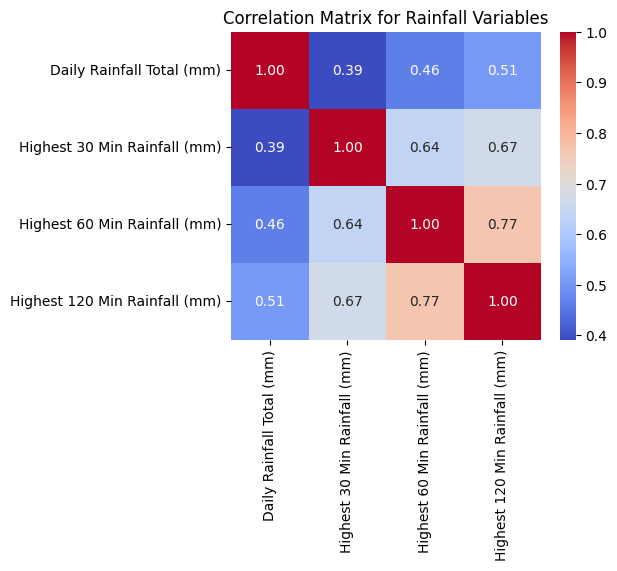

In [49]:
# If your DataFrame contains more than just rainfall variables, filter it first
rainfall_variables = merged_data.filter(like='Rainfall') 

# Calculate the correlation matrix
corr_matrix = rainfall_variables.corr()

# Plot the heatmap
plt.figure(figsize=(5, 4))  # Adjust the figure size as necessary
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Rainfall Variables')
plt.show()

From the correlation matrix, it seems like the variables are not very correlated, hence we cannot use one of them to represent all 4 as it will result it loss of distinct information

Next, we will perform the ANOVA test. The p-values obtained from the ANOVA tests help us understand if there are statistically significant differences in the means of each numerical variable across different categories of Daily Solar Panel Efficiency. 

In [50]:
# Dictionary to hold ANOVA results
anova_results = {}

# Perform ANOVA for each numerical variable against Solar Panel Efficiency
for column in numerical_columns:
    # Group data by Solar Panel Efficiency and collect values for each group
    groups = merged_data.groupby('Daily Solar Panel Efficiency')[column].apply(list)
    
    # Perform ANOVA
    F, p = f_oneway(*groups)
    
    # Store the p-value in the dictionary
    anova_results[column] = p

# Display the p-values
for column, p in anova_results.items():
    print(f"{column}: p-value = {p}")

Daily Rainfall Total (mm): p-value = 0.5298690099037664
Highest 30 Min Rainfall (mm): p-value = 0.21373812943873027
Highest 60 Min Rainfall (mm): p-value = 0.009785689387372811
Highest 120 Min Rainfall (mm): p-value = 0.0001573636140332666
Min Temperature (deg C): p-value = 0.4911421901255325
Maximum Temperature (deg C): p-value = 0.0387601238807561
Min Wind Speed (km/h): p-value = 2.4459695146824393e-39
Max Wind Speed (km/h): p-value = 1.008923582794988e-112
Sunshine Duration (hrs): p-value = 5.809062266119674e-133
Cloud Cover (%): p-value = 7.107303297367476e-05
Relative Humidity (%): p-value = 0.4818464695149951
Air Pressure (hPa): p-value = 9.441646389679816e-05
Wet Bulb Temperature (deg C): p-value = 0.05353529953137748
psi: p-value = 0.5911925820249115
pm25: p-value = 0.0894699366406391


Not Statistically Significant (p > 0.05):
- `Daily Rainfall Total (mm)`
- `Highest 30 Min Rainfall (mm)`
- `Min Temperature (deg C)`
- `Relative Humidity (%)`
- `Wet Bulb Temperature (deg C)` (close to being significant)
- `psi`
- `pm25` (close to being significant)

Based on the ANOVA tests, these factors might not have a strong relationship with Solar Panel Efficiency.
<br>

Statistically Significant (0.01 < p ≤ 0.05):
- `Highest 60 Min Rainfall (mm)`
- `Maximum Temperature (deg C)`

These variables show a statistically significant difference at the 0.05 level but not at the 0.01 level, indicating a moderate relationship with Solar Panel Efficiency.
<br>

Highly Statistically Significant (0.001 < p ≤ 0.01):
- `Highest 120 Min Rainfall (mm)`
- `Cloud Cover (%)`
- `Air Pressure (hPa)`

These variables show a highly significant difference in means across the categories, suggesting a stronger relationship with Solar Panel Efficiency.
<br>

Very Highly Statistically Significant (p ≤ 0.001):
- `Min Wind Speed (km/h)`
- `Max Wind Speed (km/h)`
- `Sunshine Duration (hrs)`

These variables demonstrate a very strong statistical significance, indicating a very strong relationship with Solar Panel Efficiency. Their means vary significantly across different categories of Solar Panel Efficiency, suggesting they could be key factors influencing Solar Panel Efficiency.
<br>

<h4>Summary:</h4>
These results are consistent with the visualisation. For the statistically insignificant variables, the boxplots show that the median values are generally around the same across the 3 solar panel efficiencies.

Here is the list of numerical variables that will be used in the machine learning pipeline:
1. `Highest 60 Min Rainfall (mm)`
2. `Highest 120 Min Rainfall (mm)`
3. `Maximum Temperature (deg C)`
4. `Cloud Cover (%)`
5. `Air Pressure (hPa)`
6. `Sunshine Duration (hrs)`
7. `Average Wind Speed (km/h)` : This will be obtained by averaging `Min Wind Speed (km/h)` and `Max Wind Speed (km/h)`. The results suggest that wind speed in general has a significant impact on the dependent variable. Combining them can reduce the complexity of the model, making it more interpretable.

8. `pm25`: Including pm25 in the machine learning model is justified despite its borderline significance (p=0.089) due to its potential interaction with wind speed, a variable highly significant for solar panel efficiency. Wind speed not only affects panels directly but may also influence efficiency indirectly by carrying particulate matter `pm25` that can accumulate on or be cleared from panel surfaces, impacting their performance.


### Categorical Variables

In [51]:
# Assuming 'make_subplots', 'go', and 'merged_data' are already defined/imported
# and 'categorical_columns' is a list of your categorical column names

fig = make_subplots(rows=len(categorical_columns), cols=1, subplot_titles=categorical_columns)

for i, column in enumerate(categorical_columns):
    # Group data by Solar Panel Efficiency and count the number of occurrences in each group
    counts = merged_data.groupby(['Daily Solar Panel Efficiency', column]).size().unstack(fill_value=0)
    
    # Add bar plot for each Solar Panel Efficiency category
    for j, efficiency in enumerate(['Low', 'Medium', 'High']):
        fig.add_trace(
            go.Bar(x=counts.columns, y=counts.loc[efficiency], name=efficiency,
                   marker_color={'Low': 'lightseagreen', 'Medium': 'palevioletred', 'High': 'tomato'}[efficiency],
                   showlegend=i == 0),  # Only show legend for the first subplot
            row=i + 1, col=1
        )

    # Update y-axis title for each subplot
    fig.update_yaxes(title_text='Count', row=i + 1, col=1)

# Update layout to adjust the figure size and ensure the legend is correctly positioned
fig.update_layout(height=300*len(categorical_columns), width=800, title_text="Counts of Solar Panel Efficiency Levels Across Categorical Variables")

fig.show()

We can take a look at how the counts of the categorical variables differ between the solar panel efficiencies. This will give us an idea of which variables might be useful for predicting the daily solar panel efficiency.

The plots for `year` and `Wind Direction` show a similar pattern for all their respective categories, possibly indicating that the efficiency of solar panels is not significantly influenced by these variables.

We can further test this hypothesis using the chi-square test to determine the association between 2 categorical variables (`Daily Solar Panel Efficiency` and the categorical variable).


In [52]:
# Dictionary to hold p-values
p_values = {}

for variable in categorical_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(merged_data['Daily Solar Panel Efficiency'], merged_data[variable])
    
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the p-value associated with the variable
    p_values[variable] = p

# Print the p-values
for variable, p in p_values.items():
    print(f"{variable}: p-value = {p}")
    print(f"Statistically Significant: {p < 0.05}")
    print("\n")

Wind Direction: p-value = 0.7763327342205482
Statistically Significant: False


Dew Point Category: p-value = 0.33983283580826223
Statistically Significant: False


month: p-value = 4.3152354301485683e-07
Statistically Significant: True


year: p-value = 0.4243221649432838
Statistically Significant: False


quarter: p-value = 1.6217156743479291e-09
Statistically Significant: True


week of the year: p-value = 3.18958769970614e-05
Statistically Significant: True




The Chi-Square test results align with our hypothesis after analysing the bar plots. Therefore the categorical variables to keep are:
1. `month`
2. `quarter`
3. `week of the year`

## Summary

In this notebook, we have cleaned the datasets and performed some feature engineering. We have also explored and visualised the merged dataset and identified the features that are significantly associated with Daily Solar Panel Efficiency. These features will be used for the predictive modelling Machine Learning Pipeline.

Features to be used:

<h5>Numerical</h5>

1. `Highest 60 Min Rainfall (mm)`
2. `Highest 120 Min Rainfall (mm)`
3. `Maximum Temperature (deg C)`
4. `Cloud Cover (%)`
5. `Air Pressure (hPa)`
6. `Sunshine Duration (hrs)`
7. `Average Wind Speed (km/h)`
8. `pm25`

<h5>Catergorical</h5>

1. `month`
2. `quarter`
3. `week of the year`